In [2]:
import duckdb

In [3]:
con = duckdb.connect()
result = con.execute("""
    SELECT *
    FROM 'cleaned.parquet'
    WHERE REGION = 'Denver, CO'
    ORDER BY period_begin
    """).df()

print(result)

    period_begin period_end  period_duration region_type  region_type_id  \
0     2012-01-01 2012-01-31               30       place               6   
1     2012-01-01 2012-01-31               30       place               6   
2     2012-01-01 2012-01-31               30       place               6   
3     2012-01-01 2012-01-31               30       place               6   
4     2012-01-01 2012-01-31               30       place               6   
..           ...        ...              ...         ...             ...   
807   2025-07-01 2025-07-31               30       place               6   
808   2025-07-01 2025-07-31               30       place               6   
809   2025-07-01 2025-07-31               30       place               6   
810   2025-07-01 2025-07-31               30       place               6   
811   2025-07-01 2025-07-31               30       place               6   

     table_id  is_seasonally_adjusted      region    city     state  ...  \
0        51

In [4]:
# Hot market classification
# # Inventory: Low inventory, Low months_of_supply, Negative inventory_yoy or inventory_mom
# # Price growth: (high) median_sale_price_yoy, (positive) median_sale_price_mom, (high) median_ppsf_yoy, (high) median_list_price_yoy
# # Market speed: (low) median_dom, (negative) median_dom_yoy, (high) avg_sale_to_list, (high) sold_above_list
# # Strong demand: (high) pending_sales_yoy & homes_sold_yoy, (high) new_listings_yoy, (low or decreasing) off_market_in_two_weeks_yoy
# # Price pressure: (low) price_drops & (negative) price_drops_yoy, (high) avg_sale_to_list_mom


# Hotness_score = > 1.0         very hot market
            #       0 - 0.5     slightly above average
            #       0           typical market conditions
            #       -0.5 - 0    Cooler than average
            #       < -1.0      Very cool / buyer's market
    # Filtered hotness scores greater than 10 for contextual outliers for special circumstances that oversaturate one of the parameters for the hotness score



In [5]:
import duckdb
import pandas as pd

con = duckdb.connect()

sql = """
WITH
params AS (
  SELECT
    CAST(0.30 AS DOUBLE) AS w_price_yoy,
    CAST(0.20 AS DOUBLE) AS w_supply,
    CAST(0.20 AS DOUBLE) AS w_dom,
    CAST(0.20 AS DOUBLE) AS w_sale_to_list,
    CAST(0.10 AS DOUBLE) AS w_inventory_yoy
),
base AS (
  SELECT
    CAST(period_begin AS DATE) AS period_begin,
    city,
    state,
    COALESCE(property_type, 'All') AS property_type,
    median_sale_price_yoy,
    months_of_supply,
    median_dom,
    avg_sale_to_list,
    inventory_yoy
  FROM read_parquet('cleaned.parquet')
  WHERE city IS NOT NULL
),
stats AS (
  SELECT
    b.*,
    AVG(median_sale_price_yoy) OVER () AS avg_price_yoy,
    STDDEV_SAMP(median_sale_price_yoy) OVER () AS sd_price_yoy,

    AVG(months_of_supply) OVER () AS avg_mos,
    STDDEV_SAMP(months_of_supply) OVER () AS sd_mos,

    AVG(median_dom) OVER () AS avg_dom,
    STDDEV_SAMP(median_dom) OVER () AS sd_dom,

    AVG(avg_sale_to_list) OVER () AS avg_sale_to_list_all,
    STDDEV_SAMP(avg_sale_to_list) OVER () AS sd_sale_to_list,

    AVG(inventory_yoy) OVER () AS avg_inventory_yoy,
    STDDEV_SAMP(inventory_yoy) OVER () AS sd_inventory_yoy
  FROM base b
),
z AS (
  SELECT
    *,
    CASE WHEN sd_price_yoy = 0 OR sd_price_yoy IS NULL
         THEN NULL ELSE (median_sale_price_yoy - avg_price_yoy) / sd_price_yoy END AS z_price_yoy,
    CASE WHEN sd_mos = 0 OR sd_mos IS NULL
         THEN NULL ELSE (months_of_supply - avg_mos) / sd_mos END AS z_mos,
    CASE WHEN sd_dom = 0 OR sd_dom IS NULL
         THEN NULL ELSE (median_dom - avg_dom) / sd_dom END AS z_dom,
    CASE WHEN sd_sale_to_list = 0 OR sd_sale_to_list IS NULL
         THEN NULL ELSE (avg_sale_to_list - avg_sale_to_list_all) / sd_sale_to_list END AS z_sale_to_list,
    CASE WHEN sd_inventory_yoy = 0 OR sd_inventory_yoy IS NULL
         THEN NULL ELSE (inventory_yoy - avg_inventory_yoy) / sd_inventory_yoy END AS z_inventory_yoy
  FROM stats
),
scored AS (
  SELECT
    z.*,
    ( p.w_price_yoy     * z_price_yoy
    + p.w_supply        * (-z_mos)
    + p.w_dom           * (-z_dom)
    + p.w_sale_to_list  * z_sale_to_list
    + p.w_inventory_yoy * (-z_inventory_yoy)
    ) AS hotness_score
  FROM z
  CROSS JOIN params p
),
city_agg AS (
  SELECT
    city,
    state,
    property_type,
    AVG(z_price_yoy)          AS z_price_yoy_mean,
    AVG(-z_mos)               AS z_mos_inv_mean,
    AVG(-z_dom)               AS z_dom_inv_mean,
    AVG(z_sale_to_list)       AS z_sale_to_list_mean,
    AVG(-z_inventory_yoy)     AS z_inventory_yoy_inv_mean,
    AVG(hotness_score)        AS hotness_score_mean
  FROM scored
  GROUP BY city, state, property_type
)
SELECT *
FROM city_agg
WHERE hotness_score_mean IS NOT NULL;
"""

city_df = con.execute(sql).df()
print(len(city_df))
city_df.head()


51972


,city,state,property_type,z_price_yoy_mean,z_mos_inv_mean,z_dom_inv_mean,z_sale_to_list_mean,z_inventory_yoy_inv_mean,hotness_score_mean
0,North Attleborough Town,Massachusetts,Townhouse,-0.002903,0.133374,0.170005,0.508630,0.122634,0.180362
1,Longwood,Florida,Condo/Co-op,-0.002575,0.317986,0.159227,-0.031414,-0.234112,0.083238
2,Country Club Hills,Missouri,Single Family Residential,-0.002277,0.157256,0.117439,-0.711085,-0.426284,-0.151752
3,Lindale,Texas,Single Family Residential,-0.002925,0.281498,0.256128,0.252272,-0.153073,0.090613
4,Atlantic City,New Jersey,Condo/Co-op,-0.002888,-1.482072,-0.179369,-1.142980,0.123676,-0.549383


In [6]:
city_level = (
    city_df
    .groupby(["city", "state", "property_type"], as_index=False)
    .agg({
        "z_price_yoy_mean": "mean",
        "z_mos_inv_mean": "mean",
        "z_dom_inv_mean": "mean",
        "z_sale_to_list_mean": "mean",
        "z_inventory_yoy_inv_mean": "mean",
        "hotness_score_mean": "mean"
    })
)

city_level.head()

,city,state,property_type,z_price_yoy_mean,z_mos_inv_mean,z_dom_inv_mean,z_sale_to_list_mean,z_inventory_yoy_inv_mean,hotness_score_mean
0,Aaronsburg,Pennsylvania,All Residential,-0.001879,0.368716,-0.228813,-0.124769,-0.113333,-0.043770
1,Aaronsburg,Pennsylvania,Single Family Residential,-0.001879,0.368716,-0.228813,-0.124769,-0.113333,-0.043770
2,Abbeville,Alabama,All Residential,0.010073,-0.021550,-0.162711,-0.807370,-0.187436,-0.219273
3,Abbeville,Alabama,Single Family Residential,0.010073,-0.021550,-0.162711,-0.807370,-0.187436,-0.219273
4,Abbeville,Louisiana,All Residential,-0.002559,-1.169969,-0.185047,-0.662156,0.091158,-0.379111


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import numpy as np

feature_cols = [
    "z_price_yoy_mean",
    "z_mos_inv_mean",
    "z_dom_inv_mean",
    "z_sale_to_list_mean",
    "z_inventory_yoy_inv_mean",
    "hotness_score_mean",
]

X = city_level[feature_cols].dropna().values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

results = []
for k in range(2, 9): 
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    results.append((k, sil, dbi))
    print(f"k={k}: silhouette={sil:.3f}, davies-bouldin={dbi:.3f}")


k=2: silhouette=0.337, davies-bouldin=1.424
k=3: silhouette=0.342, davies-bouldin=1.065
k=4: silhouette=0.296, davies-bouldin=1.166
k=5: silhouette=0.306, davies-bouldin=1.126
k=6: silhouette=0.316, davies-bouldin=1.050
k=7: silhouette=0.233, davies-bouldin=1.061
k=8: silhouette=0.245, davies-bouldin=1.056


In [7]:
# k = best cluster -> highest silhouette and lowest daies-bouldin
# Silhouette score -> best k: 3 → 6
# Davies-Bouldin score -> best k:6 → 3 → 8
# Best K = 3 for best silhouette score and still valid choice for DBI
best_k = 3


kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
city_level["cluster"] = kmeans.fit_predict(X_scaled)

cluster_summary = city_level.groupby("cluster")[feature_cols].mean()
cluster_summary

,z_price_yoy_mean,z_mos_inv_mean,z_dom_inv_mean,z_sale_to_list_mean,z_inventory_yoy_inv_mean,hotness_score_mean
cluster,,,,,,
0,-0.001172,0.207519,0.090955,0.131303,-0.025855,0.092174
1,13.802664,0.297808,-0.088085,-0.030646,-0.371764,6.393284
2,-0.000771,-0.109022,-0.369840,-0.495030,-0.140423,-0.221693


Cluster 0 = Hot market
Cluster 1 = Outlier markets (super-hot)
Cluster 2 = Cold / neutral markets

Next step is to compare these clusters to some of the known hot markets like Boise ID, Reno NV, Spokane WA, tacoma WA, Colorado Springs, Fort Collins, and Albequerque NM to name a few. This will validate our hot market clustering. 

In [8]:
known_hot_markets = ["Boise", "Reno", "Asheville", "Spokane", "Tacoma", "Salt Lake City", "Colorado Springs", "Fort Collins", "Albuquerque"]
cluster_label = {0: "Warm Market", 1: "Super-Hot Outlier Market", 2: "Cold Market"}

city_level["cluster_label"] = city_level["cluster"].map(cluster_label)

city_level[
    (city_level["city"].isin(known_hot_markets))
    ][["city", "property_type", "cluster", "cluster_label", "hotness_score_mean"]]

,city,property_type,cluster,cluster_label,hotness_score_mean
1491,Asheville,All Residential,0,Warm Market,0.069735
1492,Asheville,Condo/Co-op,0,Warm Market,-0.052761
1493,Asheville,Multi-Family (2-4 Unit),2,Cold Market,-0.057714
1494,Asheville,Single Family Residential,0,Warm Market,0.081972
1495,Asheville,Townhouse,0,Warm Market,0.024661
4369,Boise,All Residential,0,Warm Market,0.211209
4370,Boise,Condo/Co-op,0,Warm Market,0.087811
4371,Boise,Multi-Family (2-4 Unit),0,Warm Market,0.091599
4372,Boise,Single Family Residential,0,Warm Market,0.219188
4373,Boise,Townhouse,0,Warm Market,0.179161


Based on the output from this validation → There is a clear consistency with the hot→warm housing markets falling under the correct cluster. I have decided to keep the property types as an extra variable in this equation rather than all residential in case this becomes a tool for buyers looking for specific property types.

Next will be a choropleth map that will demonstrate these warm markets on a choropleth map

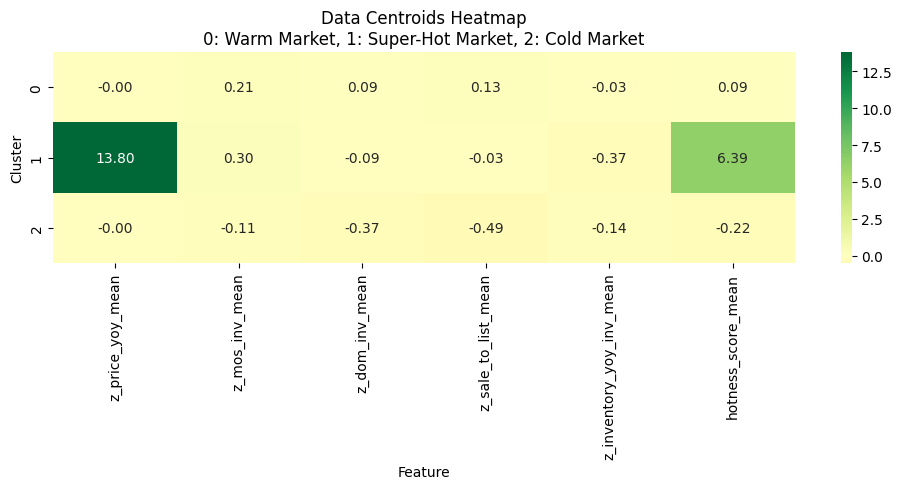

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

data_centroids = (
    city_level.groupby("cluster")[[
        "z_price_yoy_mean",
        "z_mos_inv_mean",
        "z_dom_inv_mean",
        "z_sale_to_list_mean",
        "z_inventory_yoy_inv_mean",
        "hotness_score_mean"
    ]]
    .mean()
    .round(3)
)

plt.figure(figsize=(10, 5))
sns.heatmap(
    data_centroids,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0
)

plt.title("Data Centroids Heatmap\n0: Warm Market, 1: Super-Hot Market, 2: Cold Market")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [10]:
import plotly.express as px

# Needed for plotly to properly implement state locations -> need to map these into existing state list from current database
state_name_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Same formatting as city level but grouping by state as a whole to get average for entire state to keep simplistic
state_level = (
    city_df
    .groupby(["state"], as_index=False)
    .agg({
        "z_price_yoy_mean": "mean",
        "z_mos_inv_mean": "mean",
        "z_dom_inv_mean": "mean",
        "z_sale_to_list_mean": "mean",
        "z_inventory_yoy_inv_mean": "mean",
        "hotness_score_mean": "mean"
    })
)

# Mapping state code to each state for choropleth formatting usage
state_level["state_code"] = state_level["state"].map(state_name_abbrev)

figure = px.choropleth(
    state_level,
    locations='state_code',
    locationmode='USA-states',
    color='hotness_score_mean',
    color_continuous_scale='RdYlGn',
    scope='usa',
    labels={"hotness_score_mean": "Average Hotness Score"},
    title="US Housing Market Hotness by State"

)

figure.show()

Above the choropleth map is utilizing the calculated "Hotness score" from before and plotting using plotly.express by state average. This was a simpler way to create this rather than by city which would require districts for each specific city so this was an easier demonstration. This also helps with my second question regarding geographic landmarks or features that will likely create a more consistently warmer market regardless of the time. One of those key features happens to be the coastline, where there are much warmer markets to all states that share a border with the ocean as that is a frequently desired area and makes it much easier to sell. Other features would be national parks -> more moderate climate -> mountains / access to outdoors that makes much better selling features for all property types.

<Axes: title={'center': 'Average hotness based on US region'}, xlabel='Regions of America', ylabel='Average Hotness Index'>

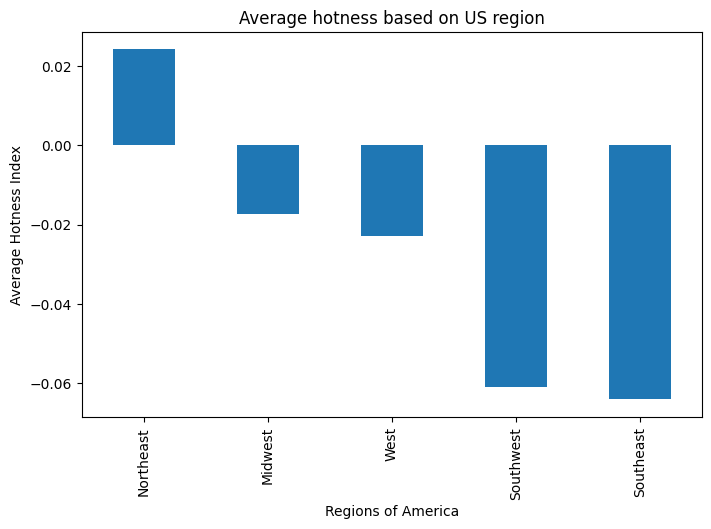

In [24]:
import matplotlib as plt

regions_of_usa = { 
        'CA':'West', 'OR':'West', 'WA':'West', 'ID':'West', 'NV':'West', 'UT':'West', 'AZ':'West', 'CO':'West', 'MT':'West', 'WY':'West', 'HI':'West', 'AK':'West',
        'NM':'Southwest', 'TX':'Southwest', 'OK':'Southwest', 
        'ND':'Midwest', 'SD':'Midwest', 'NE':'Midwest', 'KS':'Midwest', 'MN':'Midwest', 'IA':'Midwest', 'MO':'Midwest', 'WI':'Midwest', 'IL':'Midwest', 'MI':'Midwest', 'IN':'Midwest', 'OH':'Midwest', 
        'NY':'Northeast', 'NJ':'Northeast', 'PA':'Northeast', 'MD':'Northeast', 'DE':'Northeast', 'MA':'Northeast', 'CT':'Northeast', 'RI':'Northeast', 'VT':'Northeast', 'NH':'Northeast', 'ME':'Northeast', 
        'FL':'Southeast', 'GA':'Southeast', 'SC':'Southeast', 'NC':'Southeast', 'VA':'Southeast', 'WV':'Southeast', 'TN':'Southeast', 'KY':'Southeast', 'AL':'Southeast', 'MS':'Southeast', 'AR':'Southeast', 'LA':'Southeast' 
}

state_level["region"] = state_level["state_code"].map(regions_of_usa)
state_level[["state","region","hotness_score_mean"]].head()

region_comparison = (
    state_level
    .groupby("region")[["hotness_score_mean"]]
    .mean()
    .sort_values("hotness_score_mean", ascending=False)
)

region_comparison["hotness_score_mean"].plot(kind="bar", figsize=(8,5), title="Average hotness based on US region", ylabel="Average Hotness Index", xlabel="Regions of America")

After aggregating the database list into state-level housing metrics, I grouped the states by region and took an aggregate mean of the calculated hotness index to demonstrate geographically if there is a correlation with market heat and geographic location. This gave a very broad overrview as to how each region of the country is doing as a whole. Although this isn't as pinpoint and helpful as the state specific choropleth representation of market status, it still gives a good trend and gives a good basis as to conduct further analysis to answer why these specific states / regions are not doing as well as others. The next questions could be asked to include accessibility, climate, population, job market health, and a miriade of other factors that make this a much more layered and complex question rather than just geographic features that are influencing the housing market.